In [1]:
import pandas as pd
import numpy as np
from numpy import mean, std, median
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,  train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, recall_score,r2_score, accuracy_score, cohen_kappa_score, classification_report, confusion_matrix, precision_score,f1_score 
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, KFold, StratifiedKFold 
from imblearn.pipeline import Pipeline 
from imblearn.pipeline import make_pipeline as imbpipeline
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
#Random seed used in R was 7
random_seed=7

In [3]:
#read input data
#data=pd.read_csv('GS_allfeatures1.csv')
#data=pd.read_csv('EX1_Multi_GS_5.csv')
#data=pd.read_csv('GS_allfeat_appears.csv')
#data=pd.read_csv('GS_allagree_allfeat.csv')
data=pd.read_csv('AA_norm.csv')

In [4]:
d_tools=pd.DataFrame(data.loc[data['domain_x']=='tool'])
d_fruit=pd.DataFrame(data.loc[data['domain_x']=='fruit'])
d_music=pd.DataFrame(data.loc[data['domain_x']=='music'])
d_furn=pd.DataFrame(data.loc[data['domain_x']=='furn'])
d_garm=pd.DataFrame(data.loc[data['domain_x']=='garm'])

In [5]:
three=data[data['domain_x']!='furn']

In [6]:
fmt=three[three['domain_x']!='garm']

In [7]:
list(data)

['Unnamed: 0',
 'Unnamed: 0_x',
 'Unnamed: 0.1',
 'Unnamed: 0.1.1',
 'Synsets',
 'domain_x',
 'nrhypos_x',
 'nrdirhypers_x',
 'nrpartrels_x',
 'depthfromtopsynset_x',
 'glosslength_x',
 'minwordlength_x',
 'nroflemmas_x',
 'polyscore_max_x',
 'ngrams_last_mean',
 'nrpartrels_normalised_x',
 'depthfromtopsynset_normalised_x',
 'glosslength_normalised_x',
 'res_ngrams_2008_mean',
 'ngrams_2008_mean_log_y',
 'ngrams_sum08',
 'ngrams_max08',
 'All_CHILDES_mean',
 'All_CHILDES_mean_log',
 'CHILDES_sum',
 'CHILDES_Sum_log',
 'CHILDES_max',
 'CHILDES_max_log',
 'KBNC_mean',
 'KBNC_mean_log',
 'KBNC_Sum',
 'KBNC_Sum_log',
 'KBNC_max',
 'KBNC_max_log',
 'CABNC_mean',
 'CABNC_mean_log',
 'CABNC_sum',
 'CABNC_Sum_log',
 'CABNC_max',
 'CABNC_max_log',
 'BNC_mean',
 'BNC_mean_log',
 'BNC_sum',
 'BNC_Sum_log',
 'BNC_max',
 'BNC_max_log',
 'A1_Label',
 'A2_Label',
 'A3_Label',
 'MV',
 'vote_x',
 'CHILDES_Rel_mean',
 'KBNC_Rel_mean',
 'CABNC_Rel_mean',
 'BNC_Rel_mean',
 'CHILDES_Rel_mean_log',
 'KBNC_

In [8]:
#set features and target variable
features=['ngrams_last_mean',
 'dir_hypers_normalised',
 'hypos_normalised',
 'nrpartrels_normalised_x',
 'depthfromtopsynset_normalised_x',
 'glosslength_normalised_x',
 'minwordlength_x',
 'nroflemmas_x',
 'polyscore_max_x']
target=['vote_x']

In [9]:
#train on 2 domains test on one unseen to see performance across new domains
music=[d_tools, d_fruit]
fruit=[d_tools, d_music]
tools=[d_fruit, d_music]
m=pd.concat(music)
f=pd.concat(fruit)
t=pd.concat(tools)

In [10]:
#train on 4 domains test on one unseen 
garments=[d_furn, d_fruit, d_music, d_tools]
furniture=[d_fruit, d_music, d_tools, d_garm]
fru=[d_furn, d_music, d_tools, d_garm]
mus=[d_furn, d_fruit, d_tools, d_garm]
too=[d_furn, d_fruit, d_music, d_garm]
g=pd.concat(garments)
furn=pd.concat(furniture)
fr=pd.concat(fru)
mu=pd.concat(mus)
to=pd.concat(too)

In [11]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train=np.array(mu[features])
X_test=np.array(d_music[features])
y_train=np.array(mu[target])
y_test=np.array(d_music[target])

In [12]:
#skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
#skf.get_n_splits(X, y)
#for train_index, test_index in skf.split(X, y):
   # print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]

In [13]:
#run SMOTE algorithm to deal with class imbalances - make basic class same amount as non-basic
sm = SMOTE(random_state=random_seed, k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)
print ('Shape of oversampled data: {}'.format(X_train.shape))
print ('Shape of Y: {}'.format(y_train.shape))

Shape of oversampled data: (1170, 9)
Shape of Y: (1170,)


In [14]:
#define model and fit oversampled training sets
rf = RandomForestClassifier(random_state=random_seed, max_features="sqrt", n_estimators=500, oob_score=True, criterion='gini', bootstrap=True).fit(X_train, y_train.ravel())

In [15]:
kappa_scorer=make_scorer(cohen_kappa_score)

In [16]:
pipeline=imbpipeline(sm, rf)

In [17]:
#predict test set from training split
y_pred = pipeline.predict(X_test)
cr=(classification_report(y_test,y_pred, output_dict=True))
report=pd.DataFrame(cr).transpose()
report
cr=(classification_report(y_test,y_pred, output_dict=True))
ck=(cohen_kappa_score(y_test, y_pred))
ba=(balanced_accuracy_score(y_test, y_pred))
report=pd.DataFrame(cr).transpose()
report['Cohen Kappa']=ck
report['Balanced Accuracy']=ba

In [18]:
report['Trained on']='fruit tools music furn '
report['Tested on']='garments'

In [19]:
report

,precision,recall,f1-score,support,Cohen Kappa,Balanced Accuracy,Trained on,Tested on
b,0.757576,0.531915,0.625000,47.000000,0.458298,0.715325,fruit tools music furn,garments
nb,0.763441,0.898734,0.825581,79.000000,0.458298,0.715325,fruit tools music furn,garments
accuracy,0.761905,0.761905,0.761905,0.761905,0.458298,0.715325,fruit tools music furn,garments
macro avg,0.760508,0.715325,0.725291,126.000000,0.458298,0.715325,fruit tools music furn,garments
weighted avg,0.761253,0.761905,0.750761,126.000000,0.458298,0.715325,fruit tools music furn,garments


Feature: 0, Score: 0.10529
Feature: 1, Score: 0.05429
Feature: 2, Score: 0.08980
Feature: 3, Score: 0.12985
Feature: 4, Score: 0.34303
Feature: 5, Score: 0.07330
Feature: 6, Score: 0.07650
Feature: 7, Score: 0.03615
Feature: 8, Score: 0.09180


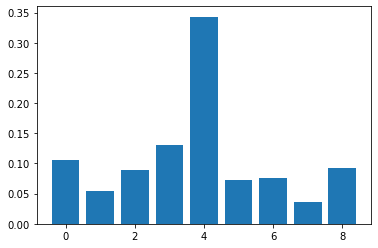

In [20]:
# get feature importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig1=plt.figure()
a=plt.bar([x for x in range(len(importance))], importance)
#plt.savefig('ck/feature_importance_global.png')
plt.show()

In [21]:
imp=[]
for i,v in enumerate(importance):
    imp.append(v)

In [22]:
df4=pd.DataFrame(imp)
df4['Features']=features
df4=df4.rename(columns={0:'Importance'})

In [23]:
df5=df4[['Features', 'Importance']].sort_values('Importance',ascending=False)

In [24]:
df5=df5.rename(columns={'index':'Rank'})

In [25]:
df5

,Features,Importance
4,depthfromtopsynset_normalised_x,0.383671
5,glosslength_normalised_x,0.132467
6,minwordlength_x,0.100596
0,ngrams_last_mean,0.097223
8,polyscore_max_x,0.081434
1,dir_hypers_normalised,0.070928
3,nrpartrels_normalised_x,0.058471
2,hypos_normalised,0.042715
7,nroflemmas_x,0.032496


In [26]:
report.to_csv('results/ex1/CR_fruit_unseen_AA.csv')

In [27]:
df5.to_csv('results/ex1/FI_fruit_unseen_AA.csv')